# Case Study of the'TinyStories' Dataset
The 'TinyStories' dataset is a large dataset that was generated using AI story request prompts and responses. It helps facilitate quick fine-tuning of models that were trained with real-world data - such as LLaMA. As this is a large dataset, and this data was generated with the help of AI, the data may have unintentionally been skewed or biased during generation. It is essential to examine the contents of this dataset and whether it is suitable to our applications content-moderation objectives with regard to literacy, mental-health, and creativity.

In [25]:
# importing libraries
from pyspark.sql import SparkSession
from datasets import load_dataset

In [26]:
from pyspark.sql.functions import udf, col, countDistinct
from pyspark.sql.types import StringType, ArrayType, IntegerType
from pyspark.accumulators import AccumulatorParam 

In [27]:
import pandas as pd

## Setting up the Distributed Processing Environment
In this section, the spark distributed cluster is connected using AWS's elastic map reduce service via sagemaker studio.

In [28]:
%load_ext sagemaker_studio_analytics_extension.magics
%sm_analytics emr-serverless connect --application-id 00fra2001bfrlm09 --language python --emr-execution-role-arn arn:aws:iam::597161074694:role/service-role/AmazonEMR-ServiceRole-20250211T131858

The sagemaker_studio_analytics_extension.magics extension is already loaded. To reload it, use:
  %reload_ext sagemaker_studio_analytics_extension.magics
Initiating EMR Serverless connection..
The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,00frdv26uqfi290a,pyspark,idle,"<a target=""_blank"" href=""https://j-00frdv26uqfi290a.dashboard.emr-serverless.us-east-1.amazonaws.com/?authToken=eDAxJQ4-OOXhhPMHk8i98DPinotvFb8Xt8KMrpSyFZScEicfaoGKFXrxLRfcmzKjv_P6yI_eehBVrthYZ7WZNcJKiZd0SX7vDSZmO54CP1cuvfp4TfhlPDpRFxYMYRK1m4s5Mvpb2XCiwAoEzTcAobnhwNOFy_bDgEw6-eDBT_9FgSocxpL--dU2wyHT-QjD_OvbbZEDPyhCcQG_H-10wfOXDMztFaty8M2IZ5pCYjFN9QMu_cBspx2NG6HY3Z0cAyRuu6FntjK5CaPU496R_jloDM9B2N3Yy8ZheXNWbw9fXRw5ECPfDElO_4Z-zw7tvw55WV-dKbU7I5ajpPZP47bUjLYJtJNRsi0H__t2NO3_M_IxO5oAIPw0UWqF57zqxtulhO-n8RssHiqkNDpmadxTcnYg6UbL6iyt1xC_jwNpdrB5vXkZtQw4iumM_2T3kANDaPNG54GTZ5L0JEs9aWemtzPeAHsaPOO3I46Lla_tIgoFOs9pJkRXxzIe4pMA64dj7FB8NSu5DA22K62lz6P2Cg8UUDzvC-fZ0Bppw6zCr7fmmtpGmTacWbIa8-nBo3JLfCBgcHfQsVd0MCUtnfaeIC6QhuT3xANqigOMAjgeIN8j7xa51BAs6vnWdrEbRR7JE1yzoTQm3eOo8oPtgxAlgUHam1IrSKQ-bhW3JGEtSP02UTPH2HIkMjs8qbi6pgOHWM8LwwPrvghyf-ZiUIDzhh9wVRMrZwW9KnLqaD5SGCuvHipgtENKISx6IEXK0z0wgYCvw6WO55_V2bZ0L6Bs0zLxKQwpieIEFVhmQ3LWkeIype7kU0K5q0_ovkzbsbCAg7vH0bcYlOqqWz1t-zLlFaDUJJ_K0yeFrxHUo5dJ1Ygdo9WL-glC2zjSoZ8NecztgVoy1oLUf0vKVt7mKBYhXrdxZeynKohsKwCe83T5Ng.eyJraWQiOiJBUUlCQUhnTVJ1MlZyR2FFajR3bTc2dEZqMThGMUsyVFdZbkk4WXpxS0lRamg5YTZHZ0d1d040SDZFeGQ3Vmt6ODBwR09HYytBQUFBb2pDQm53WUpLb1pJaHZjTkFRY0dvSUdSTUlHT0FnRUFNSUdJQmdrcWhraUc5dzBCQndFd0hnWUpZSVpJQVdVREJBRXVNQkVFREo2UXZjMExUOWRuRCtRRkxBSUJFSUJicmJLS2h4ODBDM0pWaGY5bWRVK09mL2JuUnJnMFBwWUtibmFTV1VHMXN6bXJGdDNXUFk0U2Y1VXRMRlBnNEVDOStJdDNrS3hJdVB1S1ByS3owdDE3cXl0QXVJWjJzdlMrcU5LVVV0ZWxUb2s2RENrTjI1cVpOSWF4R3c9PSJ9"">Link","<a target=""_blank"" href=""https://j-00frdv26uqfi290a.dashboard.emr-serverless.us-east-1.amazonaws.com/logs/SPARK_DRIVER/stderr.gz?authToken=eDAxPb37OTfZWN71A3_w6B3UIlJ_w6mJkLS1Gf7RjsLwvgOHTcr0N6IEb-aq6OCE21u63m5wfOKwLlnt-q0hYZtIHEf0sZctV7PDcW-NacgYFbAttrfmUqnQvBjzD7z0V28EFeqPPrdooKnh8o4GXv0ukAw22nfsHG2V42KvpBQTvXy9jk7PuXxy9rU27wX1UrYS6B2vEOCCBdShKzvPUtzEiVd4Eu4o6Z3R-PbPrzM1EjoTzU7U4ivdb0UiTZf_QcTZ2-SP7TrZwOWHYwS0HvlhyBwHGyFN5JYkivTHlmhDtWu6EtTKfg83a_qxIhm5fEbRO9qexZu1A_RZOa1Pgsr63Ebp0UZF3ZCK41cIWfaKu1B7FPagPb8mILyj-LbYhIy9e5T9teZ4X5nqFCDgc44Nar1E9yQzFtRxq2p_O2K4KljzO7uW2hQw_zTszc3prV6hRuFh9XunDE55m0SjxBRGMzKmBvnYCtvH_voBhk2Xm3Xa0cbnxJZPbtJhFLGr97XSKe5EJl3ou2kmMULadTt0En56L7XnEFdpkoUIK-Xm-57LockjHNzUv4enDzOtao_F8X3fqqtJZ8Z5Y6i0lGF0OeTFRWAKG0BOq7q0n9WFkWUi2Su7ED-rli1vIdIWLYgn2SarzcMZYQvHB4BwD9LhtI-0lavkxNqsOtXUT1zRyYj-FBZZsHOYCDYw24KPhhqqiJHEyukwzjsUhCPg5Pxreadefu0LBdOhO0DwbrCDHYkbpp1KUCZGMJ6jDMQSEtaP8VUMSL14fD3L3Je22nr0mS6vjuOZZ0k7zR7BQPZN9DTblds6l53l3Yhn1Z8tMB7PrXn5K9FPcx9-BVOOUu3UDGk8Ec4mfBtzREpphJdUCu3WPpRQAPjIJjW_VvUJtiHTrrrp8Z1k_LfBuelQ44DOER_iMx-1YYymU6QsLZc.eyJraWQiOiJBUUlCQUhnTVJ1MlZyR2FFajR3bTc2dEZqMThGMUsyVFdZbkk4WXpxS0lRamg5YTZHZ0ZZUm9lcGFYV3lNckVlL1dJWXR5dG5BQUFBb2pDQm53WUpLb1pJaHZjTkFRY0dvSUdSTUlHT0FnRUFNSUdJQmdrcWhraUc5dzBCQndFd0hnWUpZSVpJQVdVREJBRXVNQkVFREdwWnBOMGluVCtYczdUNE1nSUJFSUJiL1A1Q3p3b3VPSk5lUmxuaG4ybkt6SzlZcTJjSDVqeEo3WU5xN0RML2JtUXpaai9WbE5DQTZmR3JFSnEvdHh5K2tOdXhVNkdUbTNyWDRWMVA2ZHgzbzd2NDBOd1F5THZLbGFYcmRuT3Z2bHJDTld0TzAwMERlZXA1YlE9PSJ9"">Link",None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [29]:
# connecting to the spark session
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "64g") \
    .appName('spark') \
    .getOrCreate()

# Statistical Metrics
In this section, the basic statistical metrics are calculated to be used for further data analysis and visualization in the following sections.

## Loading the Data

In [30]:
data = load_dataset("skeskinen/TinyStories-GPT4")

In [31]:
train = spark.createDataFrame(data['train'])

## Defining the Spark Functions

In [32]:
class WordCountAccumulator(AccumulatorParam):
    def zero(self, value):
        return {}

    def addInPlace(self, v1, v2):
        # v1 is the accumulator's current state
        # v2 is the new dictionary being added from a partition
        for word, count in v2.items():
            if word is not None and word.strip():
                v1[word] = v1.get(word, 0) + count
        return v1

In [33]:
def normalize_and_count_unique(strings):
    if strings is None:
        return None
    normalized_strings = [s.strip().lower() for s in strings if s is not None and s.strip()]
    return normalized_strings
# the sparkerized user defined function to normalize the words/features for comparison
normalize_count_udf = udf(normalize_and_count_unique, ArrayType(StringType())) # Assuming string type

In [34]:
# applying the accumulator across partitions of the dataset based on col type
def process_features_partition(partition_iterator, col_type):
    # Initialize local counter for this partition
    partition_features = {}
    
    # Process each row in the partition
    for row in partition_iterator:
        features = row["normalized_" + col_type]
        if features is not None:
            # Handle both string and list cases
            words = features.split() if isinstance(features, str) else features
            
            # Count words in this row
            for word in words:
                if word and word.strip():
                    word = word.strip()
                    partition_features[word] = partition_features.get(word, 0) + 1
    
    # Add the partition counts to the accumulator
    if partition_features and col_type == 'features':
        features_accumulator.add(partition_features)
    elif partition_features and col_type == 'words':
        words_accumulator.add(partition_features)
    
    # Return the iterator for the partition
    return iter([1])  # Return dummy value to force evaluation

## Data Prep

### Adding the Normalized Columns For Words/Features
UDF / user defined functions applied on the spark dataset should be added as columns prior to partitioning / converting the dataset.

In [35]:
train = train.withColumn("normalized_features", normalize_count_udf(col("features")))

In [36]:
train = train.withColumn("normalized_words", normalize_count_udf(col("words")))

### Partitioning the Dataset for Mapping the Accumulator

In [37]:
# Ensure proper partitioning
num_partitions = 200  # Adjust based on your cluster size
train = train.repartition(num_partitions)

In [38]:
# Verify the number of partitions
print(f"Number of partitions: {train.rdd.getNumPartitions()}")

25/04/01 20:27:27 WARN TaskSetManager: Stage 0 contains a task of very large size (223671 KiB). The maximum recommended task size is 1000 KiB.
[Stage 0:=====================>                                   (6 + 10) / 16]

Number of partitions: 200


[Stage 0:=======================================>                 (11 + 5) / 16]

### Narrative Features

In [39]:
train.columns

['features',
 'prompt',
 'source',
 'story',
 'summary',
 'words',
 'normalized_features',
 'normalized_words']

In [40]:
features_accumulator = spark.sparkContext.accumulator(
    {}, WordCountAccumulator())

In [41]:
# Force evaluation and verify processing
col_type = "features"  # or whatever column name you want to process
total_partitions = train.rdd.mapPartitions(
    lambda partition: process_features_partition(partition, col_type)
).count()

In [42]:
# Get the final word counts
features_accumulator.value

{'dialogue': 1470404,
 'moralvalue': 274152,
 'twist': 539383,
 'foreshadowing': 250789,
 'badending': 250300,
 'conflict': 250696}

In [43]:
feature_occurences = pd.Series(features_accumulator.value)
feature_occurences

dialogue         1470404
moralvalue        274152
twist             539383
foreshadowing     250789
badending         250300
conflict          250696
dtype: int64

### Key Words

In [45]:
words_accumulator = spark.sparkContext.accumulator(
    {}, WordCountAccumulator())

In [46]:
# Force evaluation and verify processing
col_type = "words"  # or whatever column name you want to process
total_partitions = train.rdd.mapPartitions(
    lambda partition: process_features_partition(partition, col_type)
).count()

In [47]:
word_occurrences = pd.Series(words_accumulator.value)
word_occurrences.head()

say           6978
wait          2566
curious      11235
embarrass     7051
leaf          2633
dtype: int64

In [49]:
spark.stop()

# Statistical Analysis and Visualization
In this section the statistical metrics calculated from the training data is analyzed and visualized for making insights with regards to the stated objectives. Furthermore, given the complexity in understanding the level of literacy from the data - as no 'literacy level' column is within the data - a language model is used to classify the responses.

## Mental Health
As for mental-health, goals may be defined in objective terms by inferring the emotions, subjects, topics, genres, or any commonly used keywords related to mental-health within the data. For this purpose, we can use the list of words and narrative features provided within the prompts provided to the AI in the training data for each row in the dataset. By counting the occurences of the 'words' and 'features' columns used within the prompt, we can make some insights of the mental-health objectives.

### Narrative Features
Some of the 'feature narrative' words provided to the model within the prompt template's in the training dataset give insight into whether the story may contain any emotional subjects or topics related to mental health. A bar plot is shown that highlights the amount of each feature narrative.

<Axes: >

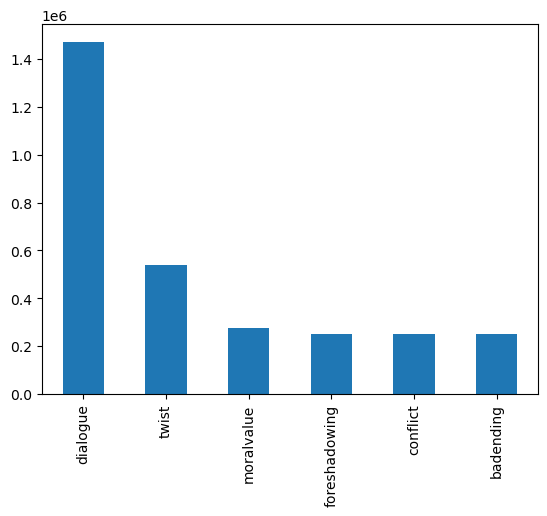

In [56]:
feature_occurences.sort_values(ascending=False).plot(kind='bar')

In [51]:
feature_occurences.describe()

count    6.000000e+00
mean     5.059540e+05
std      4.859297e+05
min      2.503000e+05
25%      2.507192e+05
50%      2.624705e+05
75%      4.730752e+05
max      1.470404e+06
dtype: float64

### Key Words

## Creativity
Objectively speaking, creativity is a hard goal to define as it can be objectively defined in a multitude of way, as are the aforementioned topics of literacy and mental-health. However, many people might agree that creativity is somehow unique. Therefore, it may be possible to define the goal of creativity by understanding the level of variance in the models responses to similar prompts. 

### Narrative Features

### Key Words

## Literacy
WonderWords' literacy goals may be defined in objective terms by classifying whether the responses are at a lower or a higher reading level. As our application is targeting a youth demographic, utilizing the categorization system used in most libraries and school systems will help illustrate whether the training data is biased towards a specific set of reading levels.

### Narrative Features

### Key Words